In [1]:
# VENV TO USE: env_general_desktop

%matplotlib inline

import SAIL_python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.use('TKagg')
import seaborn as sns
from tqdm.auto import tqdm
tqdm.pandas()
import pickle
import math

import os
os.chdir('p:/postb/work/rahim_work/')

In [2]:
# Read in tables

path = 'p:/postb/work/rahim_work/'
df_raw = pd.read_pickle(path+'pkl_dfs/raw_rahimian_study_table_2018')
admissions = pd.read_pickle(path+'pkl_dfs/all_admissions')
deaths = pd.read_pickle(path+'pkl_dfs/all_deaths')

In [5]:
# this is updated as the previous function didn't capture the rahimian methods correctly

def missingness_df(df, admissions, deaths, study_year):
    '''
    Very important - study_year here now refers to the start year of a 2 year period 
    i.e. if you want to look at the years 2016-2017, you set study_year == 2016
    because rahimian looked for outcomes 24 months after a 'start' date 
    '''
    # get patients who died in target year and merge with main table
    died = deaths[deaths['DEATH_YEAR'] == study_year][['ALF_PE','DEATH_YEAR']]
    df = df.merge(died,how ='left', on = 'ALF_PE')
    # drop patients that died before the target year
    df = df[~df.ALF_PE.isin(deaths[deaths['DEATH_YEAR'] < study_year]['ALF_PE'])]
    # fill death col with 0s if patient not recorded as dying that year
    df['DEATH_YEAR'] = df['DEATH_YEAR'].fillna(0)

    # get age at beginning of study period 
    df['study_age'] = study_year - df['BIRTH_YEAR']
    df = df.query('study_age >=18')

    # get admissions for target year
    admissions_target_years = admissions[['ALF_PE', f'ADM_{study_year}', f'ADM_{study_year+1}']]
    # merge with main table
    df = df.merge(admissions_target_years, how = 'left', on='ALF_PE')
    # fill all admission years with 0s if NaN - presume no admission
    cols = pd.Series(df.columns)
    cols = cols[cols.str.contains('adm_', case=False)]
    df[cols] = df[cols].fillna(0)

    # create a column to indicate if a patient died or was admitted in target year
    def admit(dataframe):
        if (dataframe[f'ADM_{study_year}']>=1 or dataframe[f'ADM_{study_year+1}']>=1):
            return 1
        else:
            return 0

    tqdm.pandas()
    # this may take a while to run with the whole dataset
    print('Creating death or admission outcome column: ')
    df['admit'] = df.apply(admit, axis=1)

    # mutate dataframe to replace dates of diagnosis with 1/0 if diagnosis present for study year
    # if year of diagnosis is less than study year then presume diagnosis present (1), otherwise presume diagnosis absent (0)
    def diagnosis_filler(x):
        if pd.isnull(x):
            return 0
        elif pd.to_datetime(x, errors='coerce').year < study_year: # coercing errors returns NaT where date is invlid
            return 1
        else:
            return 0

    # columns to mutate
    # df.columns.tolist()
    cols = ['HYPERTENSION', 'DIABETES', 'AF', 'IHD', 'VTE', 'CKD', 'VALVULAR', 'CCF', 'CANCER', 'ASTHMA_COPD',
            'EPILEPSY', 'FALLS', 'DEPRESSION', 'CHOL', 'MANIA_SCHIZO', 'CLD_PANC', 'RA_SLE',
            'OA', 'CTD', 'HEMIPLEGIA', 'HIV', 'LDS', 'OBESITY', 'OSTEOPOROSIS', 'PVD', 'PUD', 'DRUG_ABUSE']

    print('Converting PMH columns: ')
    for col in cols:
        df[col] = df[col].apply(diagnosis_filler)

    # fill ethnicity, lsoa, marital_status column with unknown if null
    df[['ETHNICITY','LSOA_DESC', 'MARITAL_STATUS']] = df[['ETHNICITY','LSOA_DESC', 'MARITAL_STATUS']].fillna('unknown')

    # fill WIMD values with median (needs to be rounded as WIMD values are integers)
    df['WIMD_2014_DECILE'] = df['WIMD_2014_DECILE'].fillna(np.round(df['WIMD_2014_DECILE'].median()))

    # fill smoking and etoh columns with 'no' - assume non-smoker/drinker if unknown
    df[['SMOKING','ETOH']] = df[['SMOKING','ETOH']].fillna('no')

    # fill FH column with 0 (no family history of diseased recorded)
    df['FH'] = df['FH'].fillna(0)

    # fill BMI column with median BMI
    df['BMI'] = df['BMI'].fillna(df['BMI'].median())

    # fill gp_visits/hosp_visits with 0 if null
    df[f'GP_VISITS_{study_year-1}'] = df[f'GP_VISITS_{study_year-1}'].fillna(0)
    df[f'HOSP_VISITS_{study_year-1}'] = df[f'HOSP_VISITS_{study_year-1}'].fillna(0)

    # harder to know what to do with time from admission/gp if null as this indicates there wasn't a visit
    # fill with median for now
    df['TIME_FROM_GP'] = df['TIME_FROM_GP'].fillna(100000)
    df['TIME_FROM_ADMISSION'] = df['TIME_FROM_ADMISSION'].fillna(100000)

    # repeat above for all other cols that have to do with time
    time_cols = df.columns
    time_cols = time_cols[time_cols.str.contains('_time', case=False)]

    # Fill with median value:
    # this is clearly not principled and needs to be discussed
    for col in time_cols:
        df[col] = df[col].fillna(100000)
        # # makes all values 0 if the column is all NaNs - e.g. diagnosis of HIV is uncommon
        # else:
        #     df[col] = df[col].fillna(0)
        #     print(f'{col} has no values')

    # fill indicator columns with 0 if value not present
    ind_cols = df.columns
    ind_cols = ind_cols[ind_cols.str.contains('_ind', case=False)]
    for col in ind_cols:
        df[col] = df[col].fillna(0)

    # fill abnormal blood result indicator columns with 0 if value not present
    abnormal_cols = df.columns
    abnormal_cols = abnormal_cols[abnormal_cols.str.contains('_abnormal', case=False)]
    for col in abnormal_cols:
        df[col] = df[col].fillna(0)

    # fill drug columns with 1 if a prescription was present before the study period

    drug_cols = ['STATIN', 'NSAID', 'ANTICOAG', 'STEROID', 'ANTIDEPRESS', 'ANTIPSYCH']
    for col in drug_cols:
        df[col] = df[col].apply(lambda x: 1 if x <study_year else 0)

    # fill blood test results with median values

    lab_cols = ['HB', 'CHDL', 'BILI', 'PLT', 'ESR', 'SBP']
    # there are some results that have < or > - these are mostly in the bili columns
    # if I strip the < or > signs then this will give at least give an idea of the true value
    for col in lab_cols:
        df[col] = df[col].str.lstrip('<>')
    # convert to numeric values
    for col in lab_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    # fill with median value
#     for col in lab_cols:
#         df[col] = df[col].fillna(df[col].median())

    # create dummies for relevant columns

    dummy_cols = ['ETHNICITY', 'LSOA_DESC', 'SMOKING', 'ETOH', 'MARITAL_STATUS']
    dummy_df = pd.DataFrame(index = df.index)

    # create dummies
    for col in dummy_cols:
        dummies = pd.get_dummies(df[col])
        dummies = dummies.add_prefix(f'{col.lower()}_')
        dummy_df = dummy_df.merge(dummies, how = 'left', left_index=True, right_index=True)

    df = df.merge(dummy_df, left_index=True, right_index=True, how ='left')

    # drop columns that are now represented by dummies
    df = df.drop(columns = dummy_cols)

    # turn gender col into indicator col
    df['GNDR_CD'] = df['GNDR_CD'].astype('int')
    # this turns the gender column into a dummy variable col
    # in original data 1 = male, 2 = female
    df['GNDR_CD'] = df['GNDR_CD'].apply(lambda x: 0 if x==1 else 1)

    # the whole df takes a while to create so pickle
    filename = 'missingness_df_' + str(study_year)
    pickle.dump(df, open('pkl_dfs/'+filename,'wb'))

    return df

missing_df = missingness_df(df_raw, admissions, deaths, study_year=2018)
missing_df

Creating death or admission outcome column: 
Converting PMH columns: 


,ALF_PE,BIRTH_YEAR,AGE_2017,GNDR_CD,WIMD_2014_DECILE,FH,BMI,HOSP_VISITS_2017,TIME_FROM_ADMISSION,GP_VISITS_2017,...,etoh_no,etoh_trivial,etoh_very_heavy,marital_status_cohabit,marital_status_divorced,marital_status_married,marital_status_separated,marital_status_single,marital_status_unknown,marital_status_widowed
0,170481342,1929,88,1,10.0,0.0,28.2,0.0,100000.0,0.0,...,1,0,0,0,0,0,0,0,1,0
1,170481344,1994,23,1,6.0,0.0,28.2,0.0,100000.0,0.0,...,1,0,0,0,0,0,0,0,1,0
2,170481349,1919,98,1,6.0,0.0,28.2,0.0,100000.0,0.0,...,1,0,0,0,0,0,0,0,1,0
3,170481353,1985,32,1,9.0,0.0,28.2,0.0,100000.0,0.0,...,1,0,0,0,0,0,0,0,1,0
4,170481354,1980,37,1,4.0,0.0,28.2,0.0,100000.0,0.0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3506599,28017888,1969,48,0,2.0,0.0,28.2,0.0,100000.0,0.0,...,1,0,0,0,0,0,0,0,1,0
3506600,28017891,1946,71,1,2.0,0.0,36.1,2.0,74.0,18.0,...,1,0,0,0,0,0,0,0,1,0
3506601,28017893,1930,87,0,10.0,0.0,28.2,0.0,100000.0,0.0,...,1,0,0,0,0,0,0,0,1,0
3506602,28017895,1984,33,0,4.0,0.0,28.2,0.0,100000.0,0.0,...,1,0,0,0,0,0,0,0,1,0


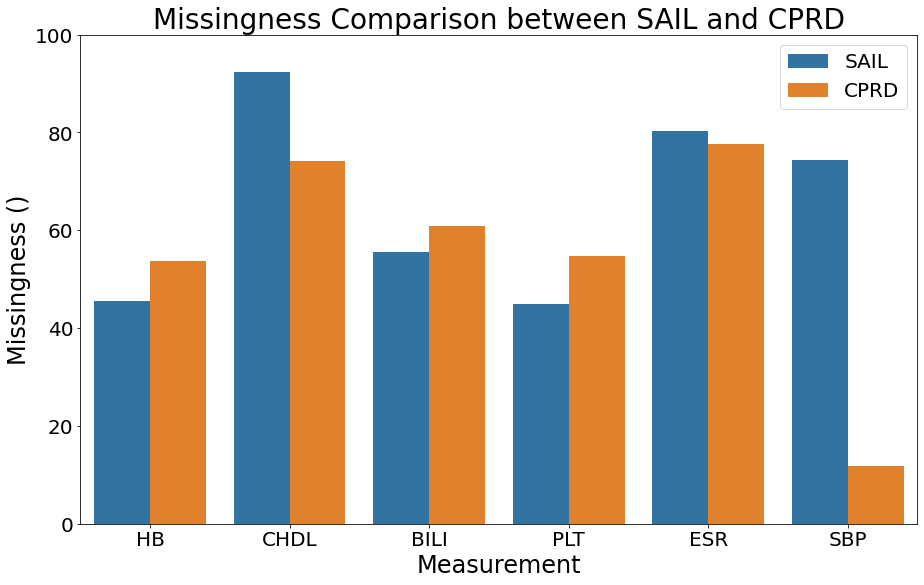

In [38]:
rahim_missing = pd.DataFrame(
    data=([.1183, .7418, .5366, .5484, .6095, .7755]),
    index = ['SBP','CHDL','HB','PLT','BILI','ESR']
)

sail_missing = (missing_df.
                filter(items = ['HB','CHDL','BILI','PLT','ESR','SBP'])
                .isnull()
                .sum()/len(missing_df)
                ).to_frame()

missingness = sail_missing.merge(rahim_missing, left_index=True, right_index=True)
missingness.columns = ['SAIL', 'CPRD']
missingness = missingness.stack().reset_index()
missingness.columns = ['measurement','database','missingness']
missingness['missingness'] = missingness['missingness']*100
# print(missingness)

fig, ax = plt.subplots(1,1,figsize=(15,9))
ax = sns.barplot(data=missingness, x='measurement',y='missingness',hue='database')
ax.set_xlabel('Measurement',fontsize=24)
ax.set_ylabel('Missingness ()',fontsize=24)
ax.set_title('Missingness Comparison between SAIL and CPRD', fontsize=28)
ax.legend(fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_ylim(0,100)

fig.savefig('plots_rahim/missingness')